<a href="https://colab.research.google.com/github/ThomasDarrieumerlou/Project_applied/blob/main/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie recommendation with sentiment



# The Dataset and The Problem to Solve


>In this notebbok, we’ll use an IMDB dataset of 50k movie reviews. The dataset contains 2 columns (review and sentiment) it show if a review is positive or negative.
>
>*Problem formulation: The goal of this project is to create a movie recommendation system using machine learning techniques to analyze user reviews. The challenge is to develop an algorithm capable of understanding user preferences from their movie reviews and then suggesting movies that are likely to be of interest based on these reviews..*


# 1. Importing necessary libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


# 2. Import the data

In [3]:
df_review = pd.read_csv("https://raw.githubusercontent.com/SK7here/Movie-Review-Sentiment-Analysis/master/IMDB-Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


This dataset contains 50000 rows; however, to train our model faster in the following steps, we’re going to take a smaller sample of 10000 rows. This small sample will contain 9000 positive and 1000 negative reviews to make the data imbalanced (so I can teach you undersampling and oversampling techniques in the next step)

In [4]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

## Dealing with Imbalanced Classes

In most cases, you’ll have a large amount of data for one class, and much fewer observations for other classes. This is known as imbalanced data because the number of observations per class is not equally distributed.

Let’s take a look at how our df_review_imb dataset is distributed.

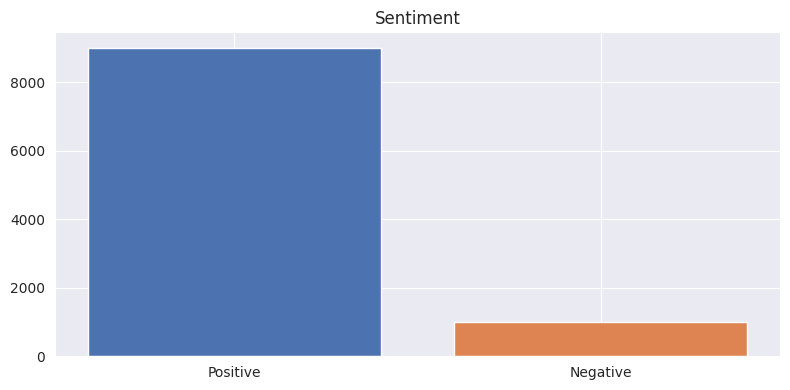

In [5]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

To resample our data we use the imblearn library. You can either undersample positive reviews or oversample negative reviews (you need to choose based on the data you’re working with). In this case, we’ll use the RandomUnderSampler

In [6]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],df_review_imb['sentiment'])


df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


We can compare the imbalanced and balanced dataset with the following code.

In [7]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
dtype: int64
sentiment
negative    1000
positive    1000
dtype: int64



## Splitting data into train and test set


In [90]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [91]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [92]:
train_y.value_counts()

negative    675
positive    665
Name: sentiment, dtype: int64


# 3.Text Representation (Bag of words)


Classifiers and learning algorithms expect numerical feature vectors rather than raw text documents. This is why we need to turn our movie review text into numerical vectors.

we’ll use bag of words (BOW) since we care about the frequency of the words in text reviews; however, the order of words is irrelevant. Two common ways to represent bag of words are CountVectorizer and Term Frequency, Inverse Document Frequency (TF-IDF)

we want to identify unique/representative words for positive reviews and negative reviews, so we’ll choose the TF-IDF. To turn text data into numerical vectors with TF-IDF

##TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)


Finally, let's also transform the test_x_vector, so we can test the accuracy of the model later

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Supposons que train_x_vector et train_x soient déjà définis
# Et tfidf soit votre TfidfVectorizer

feature_names = tfidf.get_feature_names_out()
df = pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                       index=train_x.index,
                                       columns=feature_names)


## BERT

You can use the Hugging Face Transformers library to load a pre-trained BERT model and tokenize your text dat

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT tokenizer and model, move to GPU
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Assuming df_review_bal contains your data
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

# Tokenize and encode the text data, move to GPU
max_length = 128  # Define your desired max length
X_train_tokens = tokenizer(list(train_x), truncation=True, padding=True, max_length=max_length, return_tensors="pt", add_special_tokens=True).to(device)
X_test_tokens = tokenizer(list(test_x), truncation=True, padding=True, max_length=max_length, return_tensors="pt", add_special_tokens=True).to(device)

# Calculate BERT embeddings for the text data
def generate_embeddings(tokens):
    embeddings = []
    for i in tqdm(range(len(tokens['input_ids']))):
        with torch.no_grad():
            output = bert_model(input_ids=tokens['input_ids'][i].unsqueeze(0), attention_mask=tokens['attention_mask'][i].unsqueeze(0))
        embeddings.append(output[0].squeeze().mean(dim=0).cpu().numpy())
    return embeddings

train_x_vector = generate_embeddings(X_train_tokens)
test_x_vector = generate_embeddings(X_test_tokens)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 660/660 [05:13<00:00,  2.10it/s]


# 4.Model Selection

In our example, our input (review) and output (sentiment) are clearly identified, so we can say we have labeled input and output data; therefore, we’re dealing with supervised learning.

We will benchmark the four classification models.



##  Support Vector Machine(SVM)


In [96]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')


## Decision Tree


In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of the DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV with the decision tree model and parameter grid
grid_search = GridSearchCV(dec_tree, param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the GridSearchCV (which in turn trains the decision tree model with different hyperparameters)
grid_search.fit(train_x_vector, train_y)

# Get the best decision tree model from the GridSearchCV
best_dec_tree_model = grid_search.best_estimator_

# You can now use the best_dec_tree_model for predictions or other tasks


Fitting 5 folds for each of 72 candidates, totalling 360 fits


## Random Tree

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of the RandomForestClassifier
rand_forest = RandomForestClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV with the random forest model and parameter grid
grid_search = GridSearchCV(rand_forest, param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the GridSearchCV (which in turn trains the random forest model with different hyperparameters)
grid_search.fit(train_x_vector, train_y)

# Get the best random forest model from the GridSearchCV
best_rand_forest_model = grid_search.best_estimator_

# You can now use the best_rand_forest_model for predictions or other tasks


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


##KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of the KNeighborsClassifier
knn_model = KNeighborsClassifier()

# Define the range of neighbors to test
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}  # Adjust the range as needed

# Create GridSearchCV with the KNN model and parameter grid
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the GridSearchCV (which in turn trains the KNN model with different hyperparameters)
grid_search.fit(train_x_vector, train_y)

# Get the best KNN model from the GridSearchCV
best_knn_model = grid_search.best_estimator_

# You can now use the best_knn_model for predictions or other tasks


Fitting 5 folds for each of 5 candidates, totalling 25 fits



## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create an instance of the LogisticRegression classifier
log_reg = LogisticRegression(max_iter=10000)  # Increase max_iter to ensure convergence

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 10000]  # Adjust the range as needed
}

# Create GridSearchCV with the logistic regression model and parameter grid
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the GridSearchCV (which in turn trains the logistic regression model with different hyperparameters)
grid_search.fit(train_x_vector, train_y)

# Get the best logistic regression model from the GridSearchCV
best_log_reg_model = grid_search.best_estimator_

# You can now use the best_log_reg_model for predictions or other tasks


>Note: Here notice that we are using review dataframe in vectorized form and sentiment dataframe in normal form it is so that model evaluates the vectorized values of review dataframe and gives out output in normal english not in a vectorized form so that it can be readable to us


# 5. Model Evaluation


## Mean Accuracy

In [105]:
print(svc.score(test_x_vector, test_y))
print(best_dec_tree_model.score(test_x_vector, test_y))
print(best_rand_forest_model.score(test_x_vector, test_y))
print(best_knn_model.score(test_x_vector, test_y))
print(best_log_reg_model.score(test_x_vector, test_y))

0.8045454545454546
0.6742424242424242
0.7833333333333333
0.746969696969697
0.8303030303030303


In [104]:
from sklearn.metrics import classification_report
print("LINEAR SVM")
print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))
print("Accuracy:", svc.score(test_x_vector, test_y))

print("-------")
print("Decision Tree")
print(classification_report(test_y,
                            best_dec_tree_model.predict(test_x_vector),
                            labels = ['positive','negative']))
print("Accuracy:", best_dec_tree_model.score(test_x_vector, test_y))


print("-------")
print("Random Tree")
print(classification_report(test_y,
                            best_rand_forest_model.predict(test_x_vector),
                            labels = ['positive','negative']))
print("Accuracy:", best_rand_forest_model.score(test_x_vector, test_y))

print("-------")
print("KNN")
print(classification_report(test_y,
                            best_knn_model.predict(test_x_vector),
                            labels = ['positive','negative']))
print("Accuracy:", best_knn_model.score(test_x_vector, test_y))

print("-------")
print("Logistic regression")
print(classification_report(test_y,
                            best_log_reg_model.predict(test_x_vector),
                            labels = ['positive','negative']))
print("Accuracy:", best_log_reg_model.score(test_x_vector, test_y))

LINEAR SVM
              precision    recall  f1-score   support

    positive       0.80      0.83      0.81       335
    negative       0.81      0.78      0.80       325

    accuracy                           0.80       660
   macro avg       0.81      0.80      0.80       660
weighted avg       0.80      0.80      0.80       660

Accuracy: 0.8045454545454546
-------
Decision Tree
              precision    recall  f1-score   support

    positive       0.67      0.70      0.68       335
    negative       0.68      0.65      0.66       325

    accuracy                           0.67       660
   macro avg       0.67      0.67      0.67       660
weighted avg       0.67      0.67      0.67       660

Accuracy: 0.6742424242424242
-------
Random Tree
              precision    recall  f1-score   support

    positive       0.77      0.82      0.79       335
    negative       0.80      0.75      0.77       325

    accuracy                           0.78       660
   macro avg     

SVM and Logistic Regression perform better than the other two classifiers, with SVM having a slight advantage (84% of accuracy).Thus,we’ll focus only on SVM.

## F1 Score

F1 Score is the weighted average of Precision and Recall. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed, so it’s useful when you have data with imbalance classes.

In [21]:
from sklearn.metrics import f1_score

f1_score(test_y,svc.predict(test_x_vector),
          labels = ['positive','negative'],average=None)

array([0.84671533, 0.83464567])

## Classification report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



## Confusion Matrix

A confusion matrix is a table that allows visualization of the performance of an algorithm. This table typically has two rows and two columns that report the number of false positives, false negatives, true positives, and true negatives

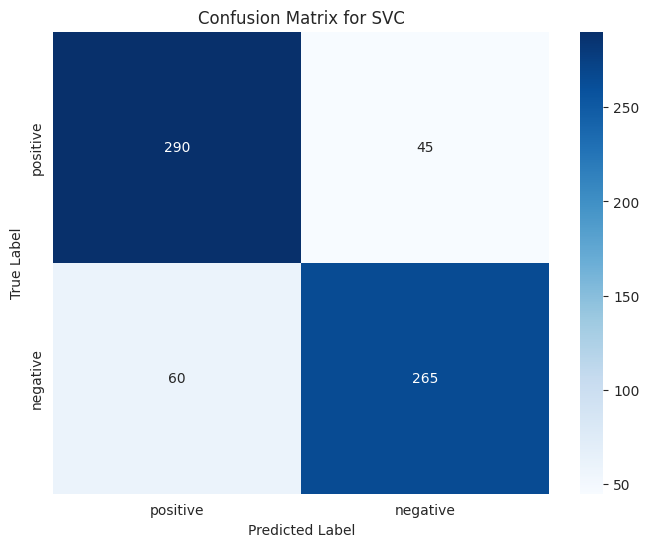

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mat = confusion_matrix(test_y, svc.predict(test_x_vector), labels=['positive', 'negative'])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative'],
            yticklabels=['positive', 'negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVC')
plt.show()


# 6. Tuning the Model


## GridSearchCV

This is technique consists of an exhaustive search on specified parameters in order to obtain the optimum values of hyperparameters.

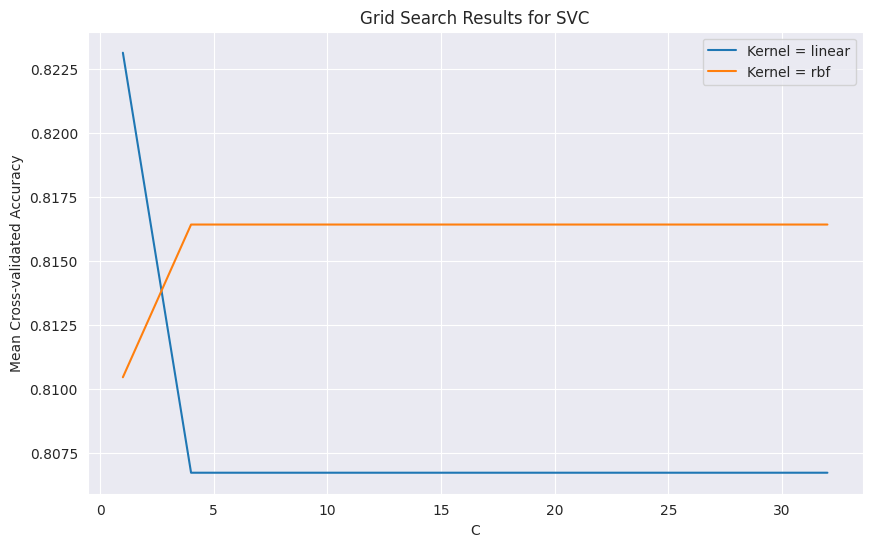

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Set the parameters
params = {'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc, params, cv=5)
svc_grid.fit(train_x_vector, train_y)

# Extract the results from the grid search
results = svc_grid.cv_results_
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
for kernel in ['linear', 'rbf']:
    subset = df[df['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'Kernel = {kernel}')

plt.title('Grid Search Results for SVC')
plt.xlabel('C')
plt.ylabel('Mean Cross-validated Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.model_selection import GridSearchCV
#set the parameters
params = {'C': [1,4,8,16,32], 'kernel' : ['linear','rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,params, cv = 5)
svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [43]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


So Above obtained paramters and kernel are the best for our model to obtain desired results as accurate as possible